## HW02 Code

### Name: Pengcheng Xu

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.  If you have trouble with the latter, a nice approach is to download in Markdown format, and then use a Markdown reader to print to PDF, which tends to produce nicer results than does printing from a browser.)

In [22]:
# import libraries as needed
import numpy as np
import pandas as pd
import math

from sklearn import linear_model
from sklearn.metrics import mean_squared_error # okay
from sklearn.preprocessing import PolynomialFeatures

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [23]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [24]:
data = pd.read_csv('data.csv')

In [25]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [26]:
def test_polynomials(polynomials=list()):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
   
    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
        
    for degree in polynomials: 
        ploy = PolynomialFeatures(degree)
        input_x = ploy.fit_transform(x)
        reg = linear_model.LinearRegression()
        reg.fit(input_x, y)
        predict_vector = input_x.dot(reg.coef_) + reg.intercept_
        
        prediction_list.append(predict_vector)
        mean_square = mean_squared_error(predict_vector, y)

        error_list.append(mean_square)
        
        
    return prediction_list, error_list
    

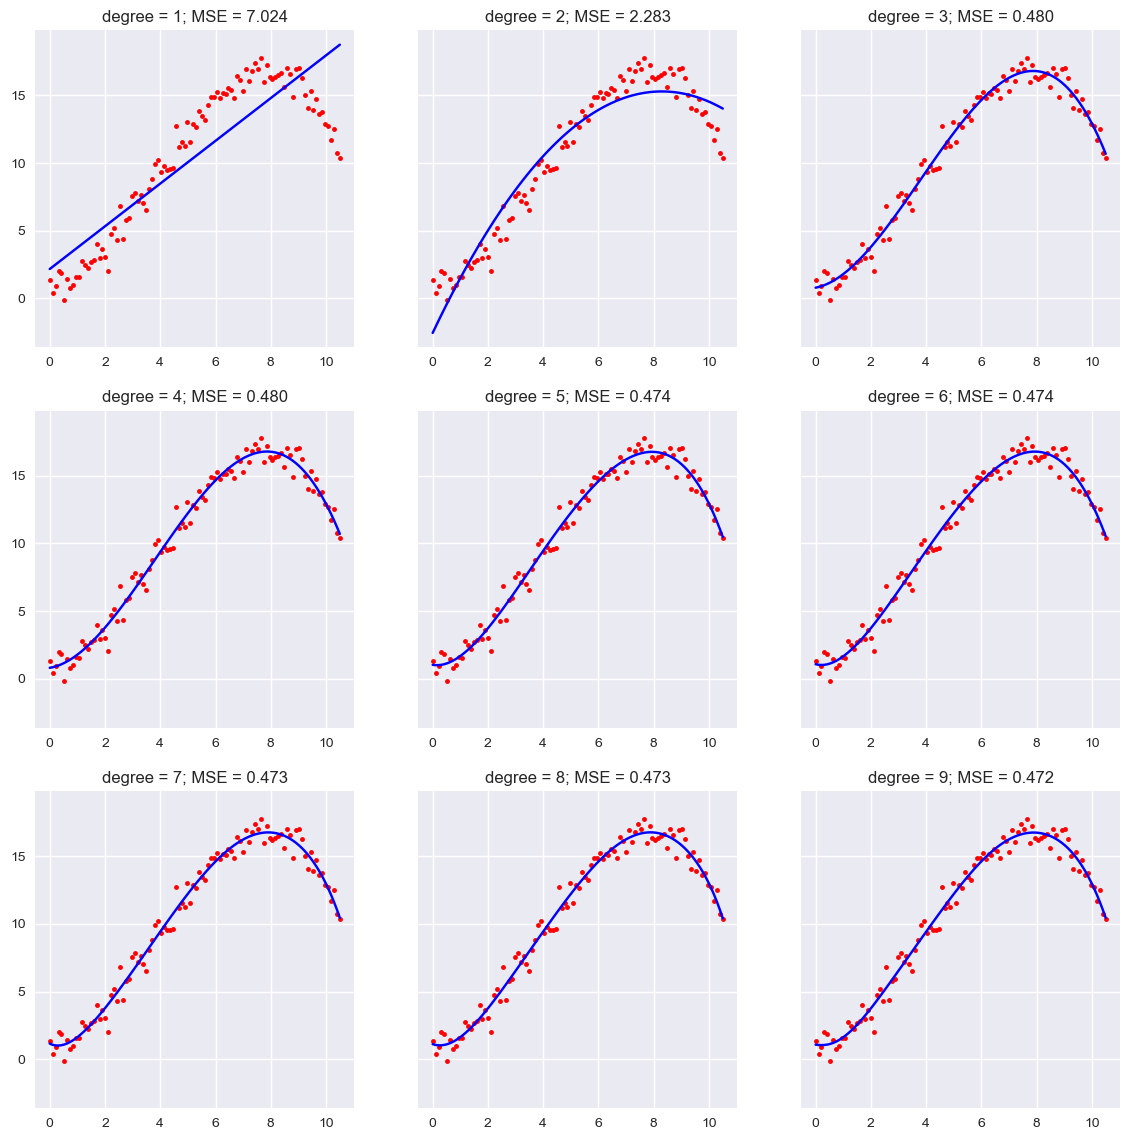

In [27]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results

# polynomial_list = [1, 2, 4, 8]
polynomial_list = [1, 2, 3,4,5,6,7,8, 9]

prediction_list, error_list = test_polynomials(polynomial_list)
plot_predictions(polynomial_list, prediction_list, error_list)

#### 1.2 Discuss the results seen in the plots above

**Discussion**:  

>The result shows that as the degree increases, the curve changes, from a straight line, to a porabola curve, to a polynomial curve, etc. While the MSE also decreases along the way.

>Based on MSE, degree 9 is the best (i.e. its MSE is 0.472, the same), degree 1 (i.e. a line) did particular poorly (i.e. its MSE is 7.024). 

>This tells us that as the degree increases, our model will fit the training data better and better.

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.  (**Don't modify this.**)

In [28]:
# A simple function for generating different data-folds.
#
# DO NOT MODIFY THIS CODE.
def make_folds(x_data, y_data, num_folds=1):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       x_data: input data.
       y_data: matching output data.
           (Expected that these are of the same length.)
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x_data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y_data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    x_folds = list()
    y_folds = list()
    
    foldLength = (int)(len(x_data) / num_folds)
    start = 0
    for fold in range(num_folds):
        end = start + foldLength
        x_folds.append(x_data[start:end])
        y_folds.append(y_data[start:end])
        start = start + foldLength
        
    return x_folds, y_folds

In [29]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.
k = 5
x_folds, y_folds = make_folds(x, y, k)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.1 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

          avg_training_err  avg_testing_err
degree 1          6.977641         7.441157
degree 2          2.245920         2.625608
degree 3          0.471621         0.558083
degree 4          0.469909         0.574623
degree 5          0.463663         0.574580
degree 6          0.462069         0.586606
degree 7          0.461471         0.584519
degree 8          0.460314         0.594491
degree 9          0.459665         0.600986


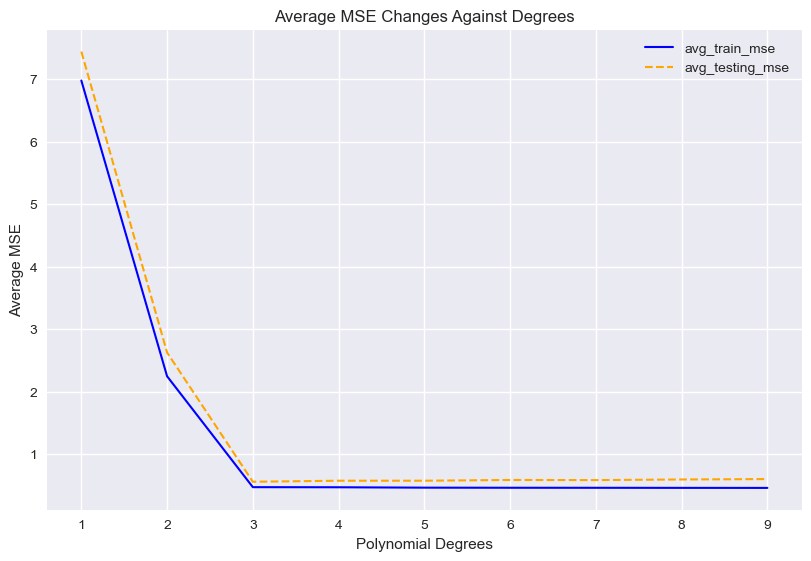

In [30]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.


def data_split(test_idx, x_folds, y_folds):
    x_train_list = [item for idx, item in enumerate(x_folds) if idx != test_idx]   
    x_train_stack = np.vstack(x_train_list)
    
    y_train_list = [item for idx, item in enumerate(y_folds) if idx != test_idx]
    y_train_stack = np.array([])
    y_train_stack = np.append(y_train_stack, y_train_list)    
  
    return x_train_stack, y_train_stack, x_folds[test_idx], y_folds[test_idx]

def fitTraningSetPredictTesting(degree, x_train_data, y_train_data, x_test_data, y_test_data, trainerr_vector, predictionerr_vector):
    
    ploy = PolynomialFeatures(degree)
    reg = linear_model.LinearRegression()
    
    x_train_data_transformed = ploy.fit_transform(x_train_data)
    reg.fit(x_train_data_transformed, y_train_data)
    train_predict_vector = x_train_data_transformed.dot(reg.coef_) + reg.intercept_
    train_mse = mean_squared_error(train_predict_vector, y_train_data)
    
    x_test_data_transformed = ploy.fit_transform(x_test_data)
    test_predict_vector = x_test_data_transformed.dot(reg.coef_) + reg.intercept_
    test_mse = mean_squared_error(test_predict_vector, y_test_data)
     
    trainerr_vector.append(train_mse)
    predictionerr_vector.append(test_mse)



def perform5CrossValidation():
    
    avg_training_err = list()
    avg_prediction_err = list()
    
    for degree in polynomial_list:
        trainerr_vector = list()
        predictionerr_vector = list()
        for i in range(5):
            x_train_data, y_train_data, x_test_data, y_test_data = data_split(i, x_folds, y_folds);
            fitTraningSetPredictTesting(degree, x_train_data, y_train_data, x_test_data, y_test_data, trainerr_vector, predictionerr_vector)
        avg_training_err.append(np.average(trainerr_vector))
        avg_prediction_err.append(np.average(predictionerr_vector))

    # draw graph
    fig1, ax = plt.subplots(layout="constrained")
    ax.plot(polynomial_list, avg_training_err, linewidth=1.5, color="blue", label="avg_train_mse")
    ax.plot(polynomial_list, avg_prediction_err, linewidth=1.5, color="orange", linestyle='--', label="avg_testing_mse")
    ax.set_title("Average MSE Changes Against Degrees")
    ax.set_xlabel("Polynomial Degrees")
    ax.set_ylabel("Average MSE")
    ax.legend()
#     fig1.show()

    # print in the tabular form
    index_str_list = [ 'degree ' + str(degree) for degree in polynomial_list]

    table = pd.DataFrame( {'avg_training_err': avg_training_err, 'avg_testing_err': avg_prediction_err}, index=index_str_list )
    print(table)
  
perform5CrossValidation()


#### 2.2 Discuss the results seen in the plots above

**Discussion:** 

>From the graph above, we could see both training MSE and testing MSE first go down and then go up, as the degree >increases. And MSEs reach the lowest value at degree 3.
>
>We think degree 3 is the best fit since it has the lowest testing MSE.
>
>Degree 1 and 2 are underfitting, since if we increase the degree, both training error and testing error would go >down, which means we could get a better fitting function.
>
>Any degree above 3 are overfitting, because even if the training error is decreasing, the testing error is becoming >bigger and bigger, which means even though our hypothesis funciton fits traning data well, its true error gets larger >and larger.


### 3. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 3.1 Cross-validation for each regularization strength value

                                    avg_training_err  avg_testing_err
reg_strength: 0.01                          0.471621         0.558036
reg_strength: 0.012067926406393288          0.471621         0.558026
reg_strength: 0.014563484775012436          0.471621         0.558015
reg_strength: 0.017575106248547922          0.471621         0.558001
reg_strength: 0.021209508879201904          0.471621         0.557984
reg_strength: 0.025595479226995357          0.471621         0.557963
reg_strength: 0.030888435964774818          0.471621         0.557939
reg_strength: 0.0372759372031494            0.471621         0.557909
reg_strength: 0.04498432668969444           0.471621         0.557873
reg_strength: 0.054286754393238594          0.471621         0.557831
reg_strength: 0.0655128556859551            0.471621         0.557779
reg_strength: 0.07906043210907697           0.471622         0.557717
reg_strength: 0.09540954763499938           0.471622         0.557643
reg_strength: 0.1151

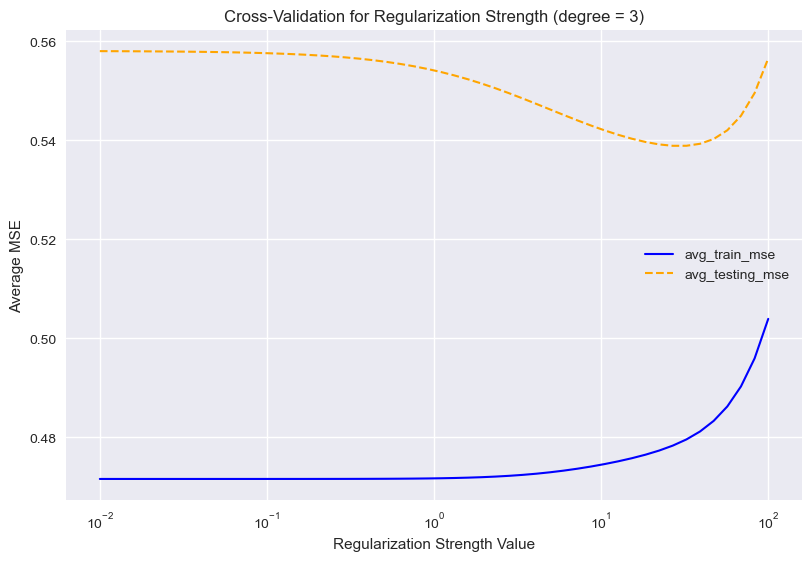

In [31]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.

def ridgeTraining(degree, reg_strength, x_train_data, y_train_data, x_test_data, y_test_data, trainerr_vector, predictionerr_vector):
    
    ploy = PolynomialFeatures(degree)
    reg = linear_model.Ridge(alpha=reg_strength)
    
    x_train_data_transformed = ploy.fit_transform(x_train_data)
    reg.fit(x_train_data_transformed, y_train_data)
    train_predict_vector = x_train_data_transformed.dot(reg.coef_) + reg.intercept_
    train_mse = mean_squared_error(train_predict_vector, y_train_data)
    
    x_test_data_transformed = ploy.fit_transform(x_test_data)
    test_predict_vector = x_test_data_transformed.dot(reg.coef_) + reg.intercept_
    test_mse = mean_squared_error(test_predict_vector, y_test_data)
     
    trainerr_vector.append(train_mse)
    predictionerr_vector.append(test_mse)

# Here we choose degree = 3, since that's the best fit degree in Question 2
def regularization_stregth_cross_validation(degree=3):
    reg_strength_list = np.logspace(-2, 2, base=10, num=50)
    
    avg_training_err = list()
    avg_prediction_err = list()
    
    for reg_strength in reg_strength_list:
        trainerr_vector = list()
        predictionerr_vector = list()
        for i in range(5):
            x_train_data, y_train_data, x_test_data, y_test_data = data_split(i, x_folds, y_folds);
            ridgeTraining(degree, reg_strength, x_train_data, y_train_data, x_test_data, y_test_data, trainerr_vector, predictionerr_vector)
        avg_training_err.append(np.average(trainerr_vector))
        avg_prediction_err.append(np.average(predictionerr_vector))
    
#     print(avg_training_err)
#     print(len(avg_training_err))
#     print(avg_prediction_err)
#     print(len(avg_prediction_err))

    # draw the graph
    fig2, ax = plt.subplots(layout="constrained")
    ax.plot(reg_strength_list, avg_training_err, linewidth=1.5, color="blue", label="avg_train_mse")
    ax.plot(reg_strength_list, avg_prediction_err, linewidth=1.5, color="orange", linestyle='--', label="avg_testing_mse")
    ax.set_title("Cross-Validation for Regularization Strength (degree = 3)")
    ax.set_xlabel("Regularization Strength Value")
    ax.set_xscale('log')
    ax.set_ylabel("Average MSE")
    ax.legend()    

    # print in the tabular form
    index_str_list = [ 'reg_strength: ' + str(reg_strength) for reg_strength in reg_strength_list]

    table = pd.DataFrame( {'avg_training_err': avg_training_err, 'avg_testing_err': avg_prediction_err}, index=index_str_list )
    print(table)    
regularization_stregth_cross_validation()

#### 3.2 Discuss the results seen in the plots above

**Discussion**:  

>When we increase regularization strength from 0.01 to 26.83, this will help up avoid overfitting, since the average testing MSE decreases along the way and reaches to the lowest point. 
>
>But after that point, increasing regularization strenth becomes less helpful ( it could even cause underfitting ), since high alpha will force the weight close to zero, which will make our model fit both training data and testing data poorly. This could be seen from the graph above ( i.e. both training and testing MSE take off exponentially).